### Helium atom

In this blog post, we'll have a look at how to solve the Schrödinger equation of the helium atom numerically and what complications we face along the way.

104.17918399649807


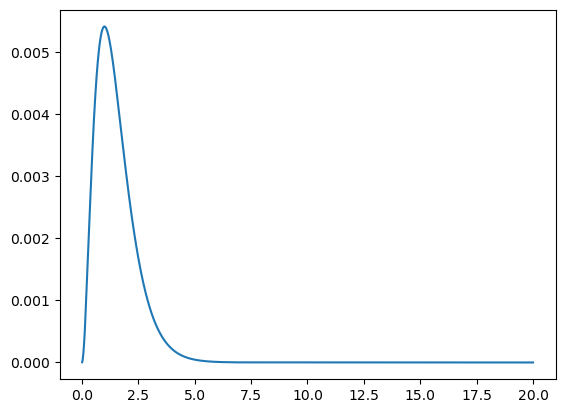

In [2]:
import numpy as np
from scipy import integrate

def solvr(U, r, E=-0.5):
    return [U[1], - U[0] * (2/r + 2*E)]

a_t = np.linspace(20, 0.0, 2000, endpoint=False)
asol = integrate.odeint(solvr, [0.0, 1.5e-7], a_t)
#plt.plot(a_t, asol[:,0]/a_t)
print(np.dot(asol[:,0].T, asol[:,0]))
plt.plot(a_t, asol[:,0]**2 / np.dot(asol[:,0].T, asol[:,0]))
plt.show()

-0.4999961448242146
-0.49999614482708454 0.9999999999999964


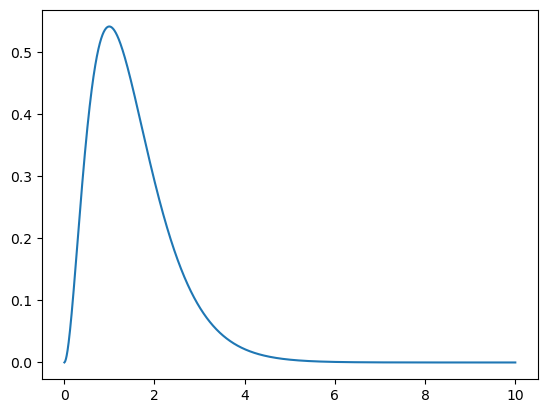

In [3]:
# 1-D Schrödinger

import numpy as np

n = 2000
x = np.linspace(10, 0.0, n, endpoint=False)[::-1]
h = x[0]-x[1]

# Solves the radial wavefunction, r*R(r)
Dxx = -2 * np.eye(n,)
b = np.ones(Dxx.shape)[0]
Dxx += np.diag(b[:-1], k=1) + np.diag(b[:-1], k=-1)
Dxx /= h**2
V = np.zeros((n,n))
# 1-D atom
V = 1.0 / x
V = np.diag(V)
w, v = np.linalg.eigh((-0.5 * Dxx - V))

import matplotlib.pyplot as plt

emin = np.argsort(w)[0]
norm = np.dot(v[:,emin].T,v[:,emin]) #*h
print(np.dot(v[:,emin], np.dot((-0.5 * Dxx - V), v[:,emin].T)))
print(w[emin], norm)

norm = integrate.simpson(v[:,emin]**2, x)
#print(integrate.simpson(v[:,emin]**2, x))

#Plot density
plt.plot(x, v[:,emin]**2 / norm)
plt.show()

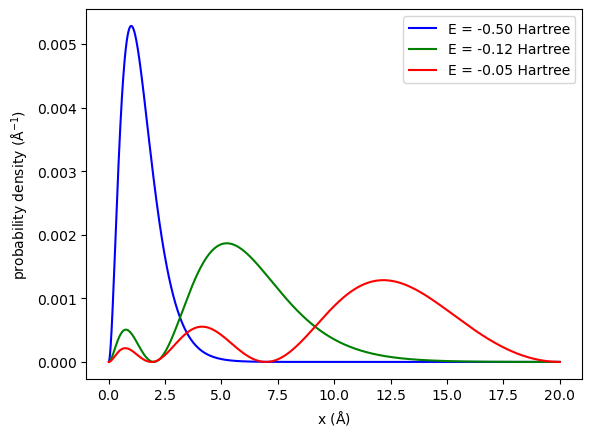

In [330]:
#From: https://physicspython.wordpress.com/2020/06/04/the-problem-of-the-hydrogen-atom-part-2/

import numpy as np
from scipy import constants as const
from scipy import sparse as sparse
from scipy.sparse.linalg import eigs
from matplotlib import pyplot as plt
 
hbar = const.hbar
e = const.e
m_e = const.m_e
pi = const.pi
epsilon_0 = const.epsilon_0
joul_to_eV = e

def calculate_potential_term(r):
    #potential = e**2 / (4.0 * pi * epsilon_0) / r
    potential = 1.0 / r
    potential_term = sparse.diags((potential))
    return potential_term
 
def calculate_angular_term(r):
    angular = l * (l + 1) / r**2
    angular_term = sparse.diags((angular))
    return angular_term
 
def calculate_laplace_three_point(r):
    h = r[1] - r[0]
     
    main_diag = -2.0 / h**2 * np.ones(N)     
    off_diag  =  1.0 / h**2 * np.ones(N - 1)
    laplace_term = sparse.diags([main_diag, off_diag, off_diag], (0, -1, 1))
    return laplace_term
     
def build_hamiltonian(r):
    laplace_term =   calculate_laplace_three_point(r)
    angular_term =   calculate_angular_term(r)
    potential_term = calculate_potential_term(r)
     
    #hamiltonian = -hbar**2 / (2.0 * m_e) * (laplace_term - angular_term) - potential_term
    hamiltonian = -0.5 * (laplace_term - angular_term) - potential_term
 
    return hamiltonian

# Everything in SI units
N = 2049
l = 0
#r = np.linspace(2e-9, 0.0, N, endpoint=False)
r = np.linspace(2e1, 0.0, N, endpoint=False)[::-1]
hamiltonian = build_hamiltonian(r)

""" solve eigenproblem """
number_of_eigenvalues = 30
eigenvalues, eigenvectors = eigs(hamiltonian, k=number_of_eigenvalues, which='SM')
 
""" sort eigenvalue and eigenvectors """
eigenvectors = np.array([x for _, x in sorted(zip(eigenvalues, eigenvectors.T), key=lambda pair: pair[0])])
eigenvalues = np.sort(eigenvalues)
 
""" compute probability density for each eigenvector """
densities = [np.absolute(eigenvectors[i, :])**2 for i in range(len(eigenvalues))]

norm = integrate.simpson(densities[0], r)

def plot(r, densities, eigenvalues):
    plt.xlabel('x ($\\mathrm{\AA}$)')
    plt.ylabel('probability density ($\\mathrm{\AA}^{-1}$)')
     
    #energies = ['E = {: >5.2f} eV'.format(eigenvalues[i].real / e) for i in range(3)]
    energies = ['E = {: >5.2f} Hartree'.format(eigenvalues[i].real) for i in range(3)]
    #plt.plot(r * 1e+0, np.exp(-r) * r**2, color='black',  label=energies[0])
    plt.plot(r * 1e+0, densities[0], color='blue',  label=energies[0])
    plt.plot(r * 1e+0, densities[1], color='green', label=energies[1])
    plt.plot(r * 1e+0, densities[2], color='red',   label=energies[2])
     
    plt.legend()
    plt.show()
    return
 
""" plot results """
plot(r, densities, eigenvalues)

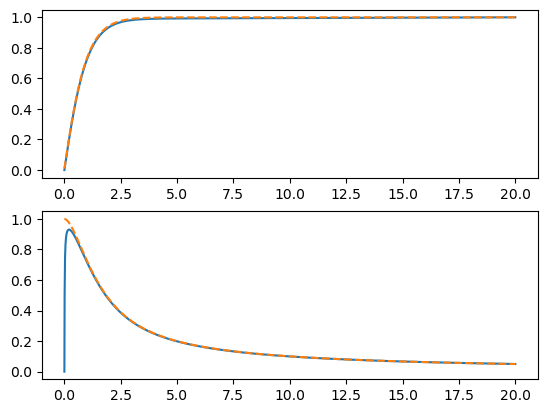

In [297]:
# Solve the Hartree potential for hydrogen atom (Thijssen, Computational physics, 5.5)

import numpy as np
from scipy.integrate import solve_bvp

def fun(x, y):
    return np.vstack((y[1], -4*x*np.exp(-2*x)))

def bc(ya, yb):
    return np.array([ya[0], 1-yb[0]]) # Boundary conditions need to be set to zero

#x = np.linspace(0.0, 20.0, 2000, endpoint=False)
x = np.linspace(2e1, 0.0, 2049, endpoint=False)[::-1]
y = np.zeros((2,x.size))
result = solve_bvp(fun, bc, x, y)

import matplotlib.pyplot as plt

plt.subplot(211)
plt.plot(x, result.y[0])
plt.plot(x, -(x+1)*np.exp(-2*x)+1, linestyle='dashed')
plt.subplot(212)
plt.plot(x, result.y[0] / x)
plt.plot(x, (-(x+1)*np.exp(-2*x)+1)/x, linestyle='dashed')
plt.show()

In [298]:
# Evaluate Hartree energy from the Hartree potential

import scipy.integrate as integrate

V_H = result.y[0] / x
E_H = integrate.romb(V_H * 4*np.pi* densities[0], dx=x[1]-x[0])
E_H_simp = integrate.simpson(V_H * 4*np.pi* densities[0], x)
E_H_anal = integrate.quad(lambda x: (-(x+1)*np.exp(-2*x)+1) * )

print(E_H, E_H_simp)

0.07552321859114039 0.07552321888319799
